# EECS 598 - Deep Learning in Computer Vision Project

## Image Classification

##### By,
##### Aman Kushwaha (UMID: 31158876), 
##### Deepthi Antony (UMID: 06685044),
##### Neha Kumar (UMID: 57554297),
##### Saurabh Budholiya (UMID: 56350227)

In this project, we build an image classification system. We collected our own image classification dataset, and trained classification models by transfer learning from networks pretrained on ImageNet. As well as, we implemented out version of ResNet__ from scratch. We explored several options and hyperparameters, and analyzed the performance of the trained networks.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab.


In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Project'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['downloads', 'test_data', 'Neha_Image_classification.ipynb', 'Deepthi_Image_classification.ipynb', 'Hyperparameters tested.gsheet', '__pycache__', 'Aman_Image_classification.ipynb', 'Trained_model', 'Saurabh_Image_classification.ipynb', 'Copy of Image_classification.ipynb', 'Copy of Final_Submission.ipynb', 'Mini Project', 'Accuracy.gsheet', 'Image_classification.ipynb', 'image_classification.py', 'Miniproject_Image_Classification.ipynb']


In [5]:
import os
import time

os.environ["TZ"] = "US/Eastern"
time.tzset()

from image_classification import hello_img


hello_img()

Hello from image_classification.py!


# **Getting Images for the Dataset**

We used the [Google Image Download](https://google-images-download.readthedocs.io/en/latest/index.html) Command Line program which web scrapes through Google Images and retrives the first N number of images, given a query.


We are primarily focused on image dataset for animals. So, our final labels in our dataset consisted of 6 categories:-

**Cat, Dog, Giraffe, Lion, Elephant, Crocodile**


In [ ]:
!pip install google_images_download

# We run the following line to save each of these queries into it's appropriate folders
# -k is used to define the keyword/query and -l is used to define the limit of images to be downloaded
# Commenting the line as it takes a while to download all images

# !googleimagesdownload -k "Elephants, Lions, Giraffes, Crocodiles, Cats, Dogs" -l 200

     |████████████████████████████████| 968 kB 37.6 MB/s 
     |████████████████████████████████| 359 kB 75.8 MB/s 
     |████████████████████████████████| 138 kB 90.7 MB/s 
     |████████████████████████████████| 3.6 MB 50.7 MB/s 
     |████████████████████████████████| 55 kB 4.8 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=cb7b70ce17194c3cf1c074d0938230db6babaf893ff5661f5aa0bce52a704b4f
  Stored in directory: /root/.cache/pip/wheels/e3/98/42/0d3a76d46cd5a6659afb2f5612d4908ca42d34060973d46727
Successfully built google-images-download
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

# **Labelling Data**

We label the data by taking advantage of the segregation of the images into folders. We use the folder name as the label for every image in it.

Furthermore, since Google Images contain the most popular or relevant image to the search query, we cannot always find exactly what we need. Thus, we manually went through each image to remove the one's which would be a bad fit for the dataset. For example, cartoon images of elephants or images that contain huge texts in it. 

Lastly, we needed to resize our image as scraping images from the internet have varying resolutions, also when we are training neural network models, we don't want our inputs to be of varying sizes and want to remain consistent. We do this while loading the data.

# **Loading Training Data**

As mentioned above, we save the labels and resize the data while loading it in our "images" tensor.

We load the data as follows

In [6]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

data_path = '/content/drive/MyDrive/Project/downloads'
categories = ['cat', 'crocodile', 'dog', 'elephant', 'giraffe', 'lion']
label = {'cat': 0,'crocodile': 1, 'dog': 2, 'elephant': 3,'giraffe': 4, 'lion': 5 }

image_data = []
image_label = []

for category in categories:
  print("Loading ", category,"images")
  path = os.path.join(data_path, category)
  for img in os.listdir(path):
    image_arr = cv2.imread(os.path.join(path, img))  #One image of dim (W, H, 3)

    #Resizing
    new_image = cv2.resize(image_arr, (224,224))   #taking image size to be (224,224,3)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

    image_data.append(new_image)
    image_label.append(label[category])
    
  
images = np.array(image_data)
labels = np.array(image_label)

print("Training images shape: " ,images.shape)      #Images are in numpy array
print("Training Labels shape: ",labels.shape)      #Labels are in numpy array

Loading  cat images
Loading  crocodile images
Loading  dog images
Loading  elephant images
Loading  giraffe images
Loading  lion images
Training images shape:  (934, 224, 224, 3)
Training Labels shape:  (934,)


# **Loading Test Data**

The test data is not downloaded from google images. As we wanted our models to be robust on different data sources

We used this website for test data source - https://unsplash.com/. For testing purpose, we downloaded images manually checking various alignment of images to ensure that the model is robust to rotation and translation. We kept 15 images per category for testing

In [7]:
#Test Data

data_path = '/content/drive/MyDrive/Project/test_data'
categories = ['cat', 'crocodile', 'dog', 'elephant', 'giraffe', 'lion']
label = {'cat': 0,'crocodile': 1, 'dog': 2, 'elephant': 3,'giraffe': 4, 'lion': 5 }

test_data = []
test_label = []

for category in categories:
  print(category)
  path = os.path.join(data_path, category)
  for img in os.listdir(path):
    test_image_arr = cv2.imread(os.path.join(path, img))  #One image of dim (W, H, 3)

    #Resizing
    new_test_image = cv2.resize(test_image_arr, (224,224))   #taking image size to be (224,224,3)
    new_test_image = cv2.cvtColor(new_test_image, cv2.COLOR_BGR2RGB)
    
    test_data.append(new_test_image)
    test_label.append(label[category])
    
  
test_images = np.array(test_data)
test_labels = np.array(test_label)

print("Test images shape: " ,test_images.shape)      #Images are in numpy array
print("Test Labels shape: ",test_labels.shape)

cat
crocodile
dog
elephant
giraffe
lion
Test images shape:  (90, 224, 224, 3)
Test Labels shape:  (90,)


We will use GPUs to accelerate our computation in this notebook.

In [8]:
import torch

#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'


cuda GPU is available


Converting our images into tensors for further computations

In [9]:
images = torch.tensor(images, device = DEVICE)
labels = torch.tensor(labels, device = DEVICE)
test_images = torch.tensor(test_images, device = DEVICE)
test_labels = torch.tensor(test_labels, device = DEVICE)

# Visualizing our Images

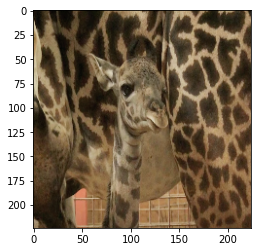

In [10]:
from image_classification import image_display

#This displays the given image
image_display(images[600])

Classes for above Images: 0 	 1 	 2 		 3 		 4 		 5


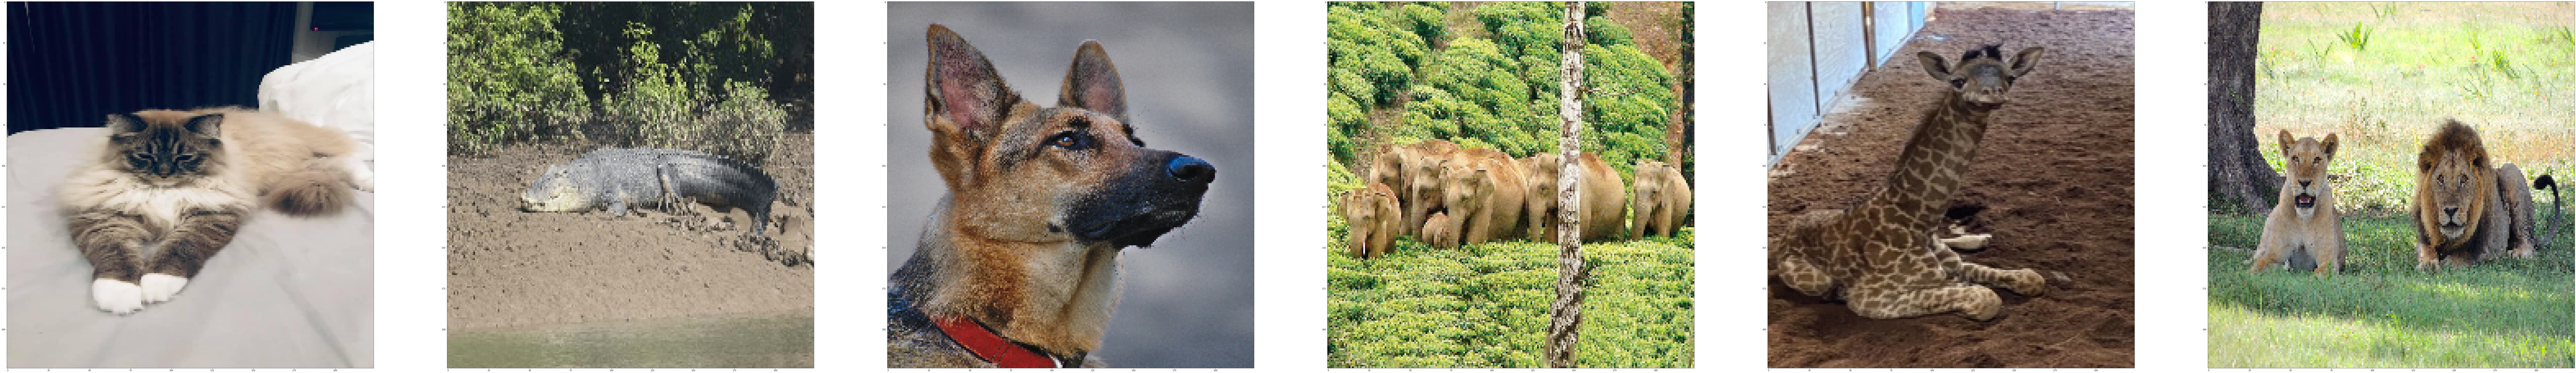

In [11]:
from image_classification import sample_image_disp

#Visualizing classes of our images
sample_image_disp(images, labels)

### Updating our image dimensions which will be accepted by the the model

In [12]:

images = images.permute(0,3,1,2)
images = images.float()

test_images = test_images.permute(0,3,1,2)
test_images = test_images.float()

# **Downloading pre-trained models from PyTorch**
The selection of pretrained models was based on various factors, some simple models with fewer layers and some deep models. The models which we used are as follows:-

1) ResNet18 <br>
2) ResNet50 <br>
3) GoogleNet <br>
4) VGG <br>
5) AlexNet <br>

We also fine tune these models. Fine-tuning is a way of applying or utilizing transfer learning. Specifically, fine-tuning is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task.

Further more, we have downloaded untrained ResNet Model and trained it using our data as well as we have implemented ResNet18 from scratch to show the comparsions

In [13]:
import seaborn as sns

# Fine Tuning on Different Pretrained Models/Architectures


## Fine tuning ResNet18

In [13]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_rn18_p = models.resnet18(pretrained = True)    #Downloading Pretrained resnet18 model from pytorch

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
from image_classification import fine_tuning

num_features = model_rn18_p.fc.in_features    #512
model_rn18_p.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_rn18_p.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rn18_p.parameters(), lr=0.001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained ResNet18 Model (Performing fine tuning on our dataset)


Epoch  0  Loss is:  1.9429999589920044
Epoch  10  Loss is:  0.12056241184473038
Epoch  20  Loss is:  0.23931825160980225
Epoch  30  Loss is:  0.1389395296573639
Epoch  40  Loss is:  0.05735574662685394
Epoch  50  Loss is:  0.13429377973079681
Epoch  60  Loss is:  0.02452687732875347
Epoch  70  Loss is:  0.09817799925804138
Epoch  80  Loss is:  0.14236101508140564
Epoch  90  Loss is:  0.054035674780607224
Epoch  100  Loss is:  0.12927041947841644
Epoch  110  Loss is:  0.008096648380160332
Epoch  120  Loss is:  0.017073223367333412
Epoch  130  Loss is:  0.02459796890616417
Epoch  140  Loss is:  0.006212628912180662
Epoch  150  Loss is:  0.035449571907520294
Epoch  160  Loss is:  0.006510694976896048
Epoch  170  Loss is:  0.006658128462731838
Epoch  180  Loss is:  0.021114546805620193
Epoch  190  Loss is:  0.08550164103507996


<function matplotlib.pyplot.show>

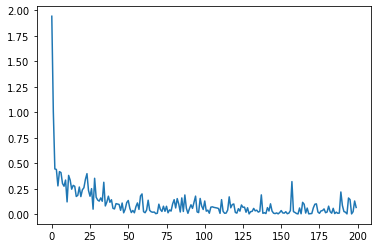

In [15]:
from image_classification import run_model

loss_graph_rn18_p = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_rn18_p, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_rn18_p.append(loss.cpu().item())

plt.plot(loss_graph_rn18_p)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on ResNet18

In [16]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_rn18_p = images[random_no]
y_batch_rn18_p = labels[random_no]
y_pred_rn18_p = model_rn18_p(x_batch_rn18_p)

y_pred_rn18_p = torch.argmax(y_pred_rn18_p, axis = 1)

train_acc_rn18_p = ((torch.sum(y_pred_rn18_p == y_batch_rn18_p))/(batch_size))*100
print("Training accuracy: ", train_acc_rn18_p.item())

Training accuracy:  98.99999237060547


In [17]:
from image_classification import calculate_accuracy

y_pred_rn18_p_ = model_rn18_p(test_images)
y_pred_rn18_p = torch.argmax(y_pred_rn18_p_, axis=1)
accuracy_rn18_p = calculate_accuracy(test_images, y_pred_rn18_p_, test_labels, test_images.shape[0])

print("The accuracy of test data on ResNet18 is: ", accuracy_rn18_p.item())

The accuracy of test data on ResNet18 is:  93.33333587646484


### Confusion Matrix - ResNet18 Pretrained

In [14]:
from image_classification import confusion_matrix_display

Confusion Matrix for ResNet18 Model


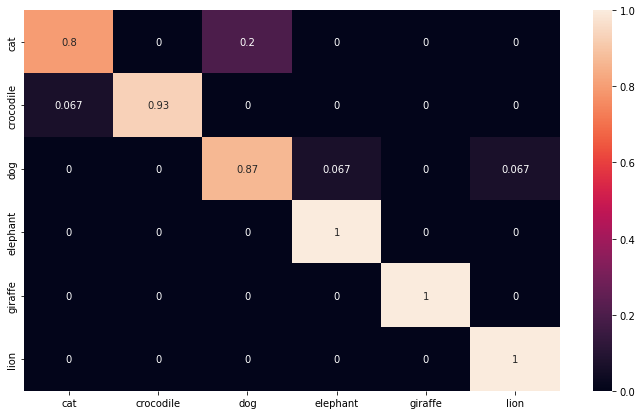

In [19]:
cf_rn18_p = confusion_matrix_display(y_pred_rn18_p, test_labels)

print("Confusion Matrix for ResNet18 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_rn18_p, annot=True)

In [15]:
from image_classification import saliency_maps

### Qualitative Examples and Saliency Map - ResNet18 Pretrained

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

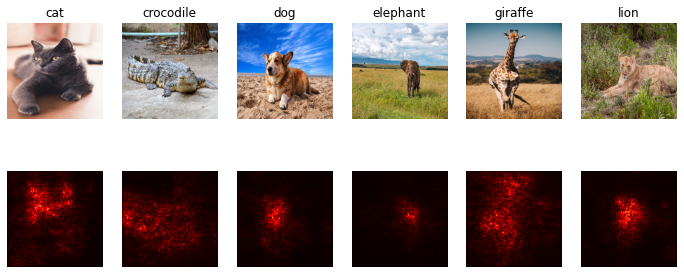

In [21]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_rn18_p[temp_img], model_rn18_p)



## Fine tuning ResNet50

In [15]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_rn50 = models.resnet50(pretrained = True)    

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
from image_classification import fine_tuning

import time
import copy

num_features = model_rn50.fc.in_features    #512
model_rn50.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_rn50.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rn50.parameters(), lr=0.001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained ResNet50 Model (Performing fine tuning on our dataset)

Epoch  0  Loss is:  1.8638077974319458
Epoch  10  Loss is:  0.33097296953201294
Epoch  20  Loss is:  0.3123326301574707
Epoch  30  Loss is:  0.3879026472568512
Epoch  40  Loss is:  0.21107709407806396
Epoch  50  Loss is:  0.12519735097885132
Epoch  60  Loss is:  0.2457074075937271
Epoch  70  Loss is:  0.14685574173927307
Epoch  80  Loss is:  0.07565315067768097
Epoch  90  Loss is:  0.13367398083209991
Epoch  100  Loss is:  0.07110540568828583
Epoch  110  Loss is:  0.07526291906833649
Epoch  120  Loss is:  0.07232491672039032
Epoch  130  Loss is:  0.037033941596746445
Epoch  140  Loss is:  0.18878594040870667
Epoch  150  Loss is:  0.04445166885852814
Epoch  160  Loss is:  0.05915718525648117
Epoch  170  Loss is:  0.25628119707107544
Epoch  180  Loss is:  0.179843932390213
Epoch  190  Loss is:  0.10860370844602585


<function matplotlib.pyplot.show>

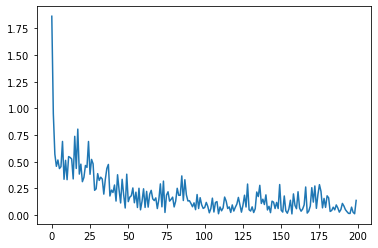

In [17]:
from image_classification import run_model

loss_graph_rn50 = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_rn50, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_rn50.append(loss.cpu().item())

plt.plot(loss_graph_rn50)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on ResNet50

In [18]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_rn50 = images[random_no]
y_batch_rn50 = labels[random_no]
y_pred_rn50 = model_rn50(x_batch_rn50)

y_pred_rn50 = torch.argmax(y_pred_rn50, axis = 1)

train_acc_rn50 = ((torch.sum(y_pred_rn50 == y_batch_rn50))/(batch_size))*100
print("Training accuracy: ", train_acc_rn50.item())

Training accuracy:  98.99999237060547


In [19]:
from image_classification import calculate_accuracy

y_pred_rn50_ = model_rn50(test_images)
y_pred_rn50 = torch.argmax(y_pred_rn50_, axis=1)
accuracy_rn50 = calculate_accuracy(test_images, y_pred_rn50_, test_labels, test_images.shape[0])

print("The accuracy of test data on ResNet50 is: ", accuracy_rn50.item())

The accuracy of test data on ResNet50 is:  92.22222900390625


### Confusion Matrix - ResNet50

Confusion Matrix for ResNet50 Model


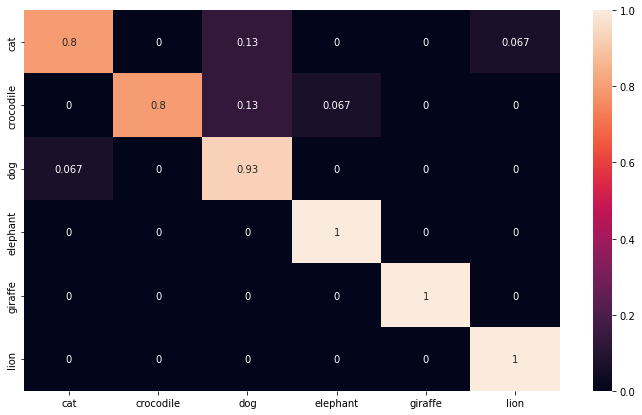

In [20]:
cf_rn50 = confusion_matrix_display(y_pred_rn50, test_labels)

print("Confusion Matrix for ResNet50 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_rn50, annot=True)

### Qualitative Examples and Saliency Map - ResNet50

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

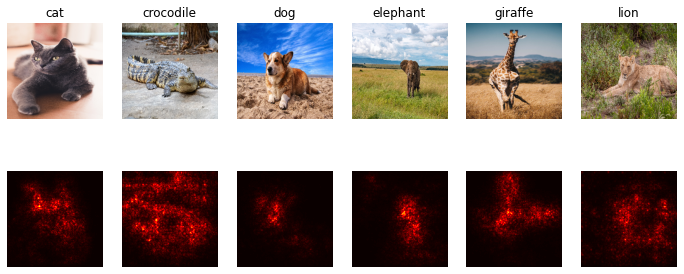

In [21]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_rn50[temp_img], model_rn50)



## Fine tuning Googlenet

In [15]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_gn = models.googlenet(pretrained = True)   

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [16]:
from image_classification import fine_tuning

import time
import copy

num_features = model_gn.fc.in_features    #512
model_gn.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_gn.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gn.parameters(), lr=0.0001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained Googlenet Model (Performing fine tuning on our dataset)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch  0  Loss is:  1.7946206331253052
Epoch  10  Loss is:  1.0563573837280273
Epoch  20  Loss is:  0.6306957006454468
Epoch  30  Loss is:  0.3557622730731964
Epoch  40  Loss is:  0.20565520226955414
Epoch  50  Loss is:  0.08951831609010696
Epoch  60  Loss is:  0.0804217979311943
Epoch  70  Loss is:  0.04141804948449135
Epoch  80  Loss is:  0.040529243648052216
Epoch  90  Loss is:  0.02819843217730522
Epoch  100  Loss is:  0.036890238523483276
Epoch  110  Loss is:  0.027561906725168228
Epoch  120  Loss is:  0.020722972229123116
Epoch  130  Loss is:  0.015107224695384502
Epoch  140  Loss is:  0.01154036819934845
Epoch  150  Loss is:  0.012275269255042076
Epoch  160  Loss is:  0.00894303247332573
Epoch  170  Loss is:  0.011456528678536415
Epoch  180  Loss is:  0.009932436048984528
Epoch  190  Loss is:  0.012758689001202583


<function matplotlib.pyplot.show>

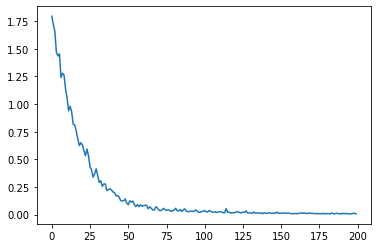

In [17]:
from image_classification import run_model

loss_graph_gn = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_gn, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_gn.append(loss.cpu().item())

plt.plot(loss_graph_gn)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on GoogleNet

In [18]:
#Calculationg training accuracy
model_gn.eval()
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_gn = images[random_no]
y_batch_gn = labels[random_no]
y_pred_gn = model_gn(x_batch_gn)

y_pred_gn = torch.argmax(y_pred_gn, axis = 1)

train_acc_gn = ((torch.sum(y_pred_gn == y_batch_gn))/(batch_size))*100
print("Training accuracy: ", train_acc_gn.item())

Training accuracy:  100.0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [19]:
from image_classification import calculate_accuracy

y_pred_gn_ = model_gn(test_images)
y_pred_gn = torch.argmax(y_pred_gn_, axis=1)

accuracy_gn = calculate_accuracy(test_images, y_pred_gn_, test_labels, test_images.shape[0])

print("The accuracy of test data on GoogleNet is: ", accuracy_gn.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


The accuracy of test data on GoogleNet is:  100.0


### Confusion Matrix - GoogleNet

In [20]:
from image_classification import confusion_matrix_display, saliency_maps
import seaborn as sns

Confusion Matrix for GoogleNet Model


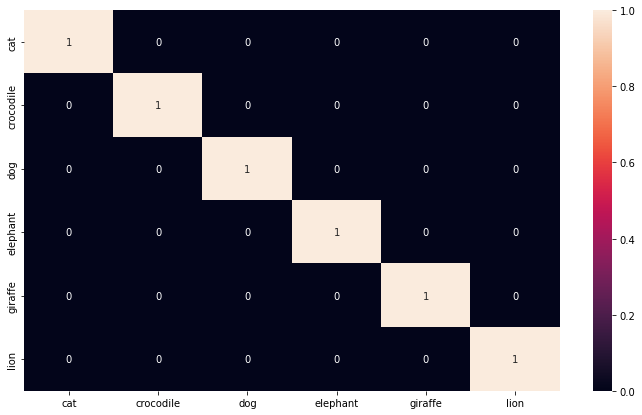

In [21]:
cf_gn = confusion_matrix_display(y_pred_gn, test_labels)

print("Confusion Matrix for GoogleNet Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_gn, annot=True)

### Qualitative Examples and Saliency Map - GoogleNet

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


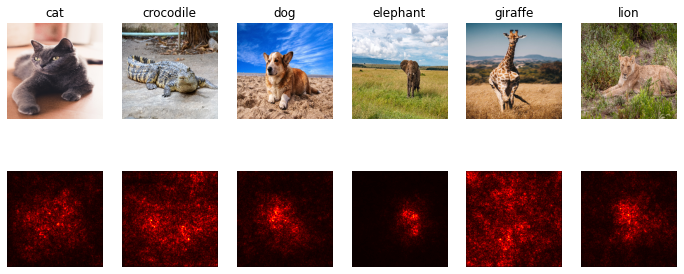

In [22]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_gn[temp_img], model_gn)

## Fine tuning VGG19

In [16]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_vgg = models.vgg19(pretrained=True)    

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [17]:
from image_classification import fine_tuning

import time
import copy

num_features = model_vgg.classifier[6].in_features    #512
model_vgg.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_vgg.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg.parameters(), lr=0.0001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained VGG19 Model (Performing fine tuning on our dataset)

Epoch  0  Loss is:  131.90347290039062
Epoch  10  Loss is:  2.661867141723633
Epoch  20  Loss is:  1.9134669303894043
Epoch  30  Loss is:  1.70574152469635
Epoch  40  Loss is:  1.581908106803894
Epoch  50  Loss is:  1.4545040130615234
Epoch  60  Loss is:  1.3238985538482666
Epoch  70  Loss is:  1.0296767950057983
Epoch  80  Loss is:  0.9895533323287964
Epoch  90  Loss is:  1.0048201084136963
Epoch  100  Loss is:  0.6187582015991211
Epoch  110  Loss is:  0.9891496896743774
Epoch  120  Loss is:  0.6096028685569763
Epoch  130  Loss is:  0.2765594720840454
Epoch  140  Loss is:  0.39216095209121704
Epoch  150  Loss is:  0.06449827551841736
Epoch  160  Loss is:  0.22551044821739197
Epoch  170  Loss is:  0.12613844871520996
Epoch  180  Loss is:  0.178362637758255
Epoch  190  Loss is:  0.1040615439414978


<function matplotlib.pyplot.show>

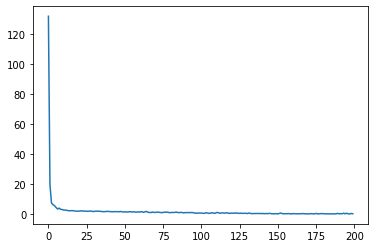

In [18]:
from image_classification import run_model

loss_graph_vgg = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_vgg, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_vgg.append(loss.cpu().item())

plt.plot(loss_graph_vgg)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on VGG

In [19]:
#Calculationg training accuracy
model_vgg.eval()
batch_size = 80
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_vgg = images[random_no]
y_batch_vgg = labels[random_no]
y_pred_vgg = model_vgg(x_batch_vgg)

y_pred_vgg = torch.argmax(y_pred_vgg, axis = 1)

train_acc_vgg = ((torch.sum(y_pred_vgg == y_batch_vgg))/(batch_size))*100
print("Training accuracy: ", train_acc_vgg)

Training accuracy:  tensor(91.2500, device='cuda:0')


In [20]:
from image_classification import calculate_accuracy

y_pred_vgg_ = model_vgg(test_images)
y_pred_vgg = torch.argmax(y_pred_vgg_, axis=1)

accuracy_vgg = calculate_accuracy(test_images, y_pred_vgg_, test_labels, test_images.shape[0])

print("The accuracy of test data on VGG is: ", accuracy_vgg.item())

The accuracy of test data on VGG is:  76.66667175292969


### Confusion Matrix - VGG19

Confusion Matrix for VGG Model


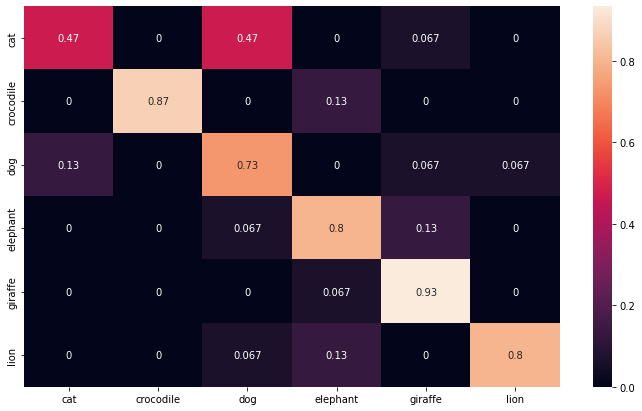

In [21]:
cf_vgg = confusion_matrix_display(y_pred_vgg, test_labels)

print("Confusion Matrix for VGG Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_vgg, annot=True)

### Qualitative Examples and Saliency Map - VGG19

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

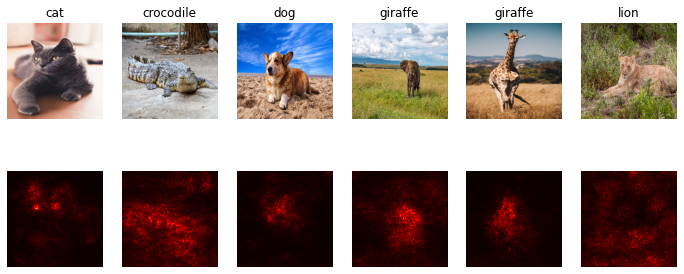

In [22]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_vgg[temp_img], model_vgg)

## Training the pretrained Alexnet Model (Performing fine tuning on our dataset)

In [28]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_an = models.alexnet(pretrained=True)    

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [29]:
from image_classification import fine_tuning

import time
import copy

num_features = model_an.classifier[6].in_features    #512
model_an.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_an.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_an.parameters(), lr=0.0001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training on the AlexNet Model

Epoch  0  Loss is:  274.8388671875
Epoch  10  Loss is:  8.234993934631348
Epoch  20  Loss is:  2.924635648727417
Epoch  30  Loss is:  2.4707674980163574
Epoch  40  Loss is:  1.9019325971603394
Epoch  50  Loss is:  1.8272844552993774
Epoch  60  Loss is:  1.921448826789856
Epoch  70  Loss is:  1.6164495944976807
Epoch  80  Loss is:  1.8022438287734985
Epoch  90  Loss is:  1.8970754146575928
Epoch  100  Loss is:  1.7165734767913818
Epoch  110  Loss is:  1.621996283531189
Epoch  120  Loss is:  1.49338698387146
Epoch  130  Loss is:  1.4273802042007446
Epoch  140  Loss is:  1.4946609735488892
Epoch  150  Loss is:  1.352433443069458
Epoch  160  Loss is:  1.250741720199585
Epoch  170  Loss is:  1.3987572193145752
Epoch  180  Loss is:  1.3020857572555542
Epoch  190  Loss is:  1.4838006496429443


<function matplotlib.pyplot.show>

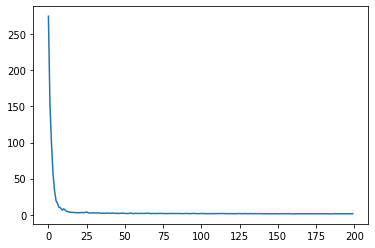

In [30]:
from image_classification import run_model

loss_graph_an = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_an, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_an.append(loss.cpu().item())

plt.plot(loss_graph_an)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on AlexNet

In [31]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_an = images[random_no]
y_batch_an = labels[random_no]
y_pred_an = model_an(x_batch_an)

y_pred_an = torch.argmax(y_pred_an, axis = 1)

train_acc_an = ((torch.sum(y_pred_an == y_batch_an))/(batch_size))*100
print("Training accuracy: ", train_acc_an.item())

Training accuracy:  50.0


In [32]:
from image_classification import calculate_accuracy

y_pred_an_ = model_an(test_images)
y_pred_an = torch.argmax(y_pred_an_, axis=1)

accuracy_an = calculate_accuracy(test_images, y_pred_an_, test_labels, test_images.shape[0])

print("The accuracy of test data on AlexNet is: ", accuracy_an.item())

The accuracy of test data on AlexNet is:  40.0


### Confusion Matrix - AlexNet

Confusion Matrix for AlexNet Model


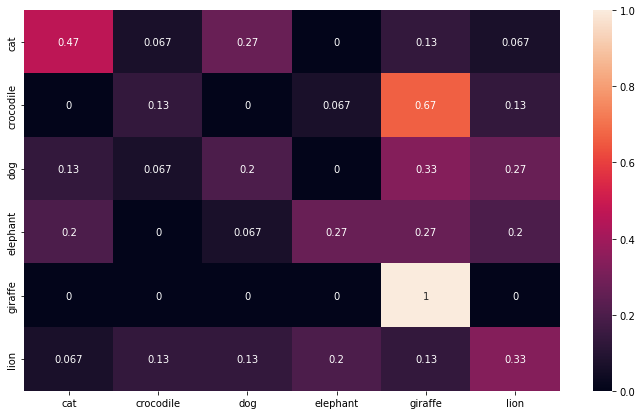

In [33]:
cf_an = confusion_matrix_display(y_pred_an, test_labels)

print("Confusion Matrix for AlexNet Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_an, annot=True)

### Qualitative Examples and Saliency Map - AlexNet

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

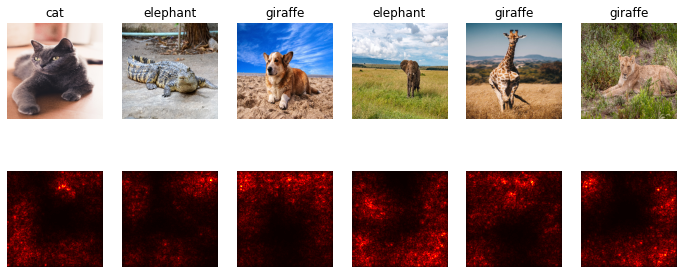

In [34]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_an[temp_img], model_an)

# **Downloading Un-trained ResNet18 Model from PyTorch**

In [35]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_rn18_u = models.resnet18()    #Downloading the untrained resnet18 model


## Fine Tuning the Untrained Resnet18 model


In [36]:
from image_classification import fine_tuning

import time
import copy

num_features = model_rn18_u.fc.in_features    #512
model_rn18_u.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_rn18_u.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rn18_u.parameters(), lr=0.001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the Untrained Resnet18 Model (Performing fine tuning on our dataset)




Epoch  0  Loss is:  1.9375035762786865
Epoch  10  Loss is:  1.6081509590148926
Epoch  20  Loss is:  1.6586414575576782
Epoch  30  Loss is:  1.3642979860305786
Epoch  40  Loss is:  1.373436689376831
Epoch  50  Loss is:  1.318382740020752
Epoch  60  Loss is:  1.0594112873077393
Epoch  70  Loss is:  0.9900397658348083
Epoch  80  Loss is:  1.0430645942687988
Epoch  90  Loss is:  1.0013015270233154
Epoch  100  Loss is:  0.66739422082901
Epoch  110  Loss is:  0.8700114488601685
Epoch  120  Loss is:  0.8631160259246826
Epoch  130  Loss is:  0.8236004114151001
Epoch  140  Loss is:  0.6361967921257019
Epoch  150  Loss is:  0.5446283221244812
Epoch  160  Loss is:  0.5562470555305481
Epoch  170  Loss is:  0.6795271635055542
Epoch  180  Loss is:  0.526340663433075
Epoch  190  Loss is:  0.3860739469528198


<function matplotlib.pyplot.show>

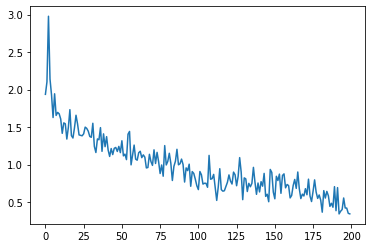

In [37]:
from image_classification import run_model

loss_graph_rn18_u = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_rn18_u, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_rn18_u.append(loss.cpu().item())

plt.plot(loss_graph_rn18_u)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on our ResNet18 Model

In [38]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_rn18_u = images[random_no]
y_batch_rn18_u = labels[random_no]
y_pred_rn18_u = model_rn18_u(x_batch_rn18_u)

y_pred_rn18_u = torch.argmax(y_pred_rn18_u, axis = 1)

train_acc_rn18_u = ((torch.sum(y_pred_rn18_u == y_batch_rn18_u))/(batch_size))*100
print("Training accuracy: ", train_acc_rn18_u.item())

Training accuracy:  85.0


In [39]:
from image_classification import calculate_accuracy

y_pred_rn18_u_ = model_rn18_u(test_images)
y_pred_rn18_u = torch.argmax(y_pred_rn18_u_, axis=1)

accuracy_rn18_u = calculate_accuracy(test_images, y_pred_rn18_u_, test_labels, test_images.shape[0])

print("The accuracy of test data on our ResNet18 model is: ", accuracy_rn18_u.item())

The accuracy of test data on our ResNet18 model is:  72.22222900390625


### Confusion Matrix - Untrained ResNet18 Model

Confusion Matrix for ResNet18 Model


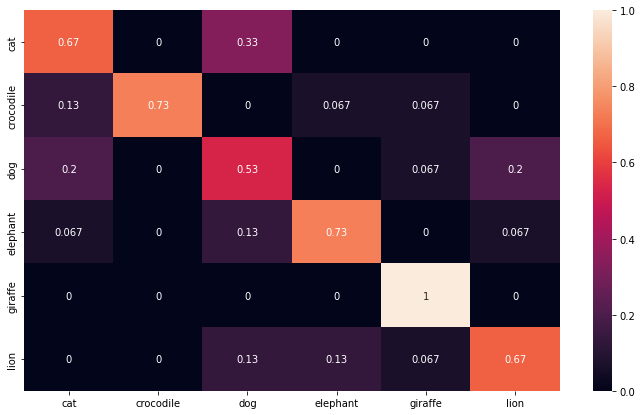

In [40]:
cf_rn18_u = confusion_matrix_display(y_pred_rn18_u, test_labels)

print("Confusion Matrix for ResNet18 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_rn18_u, annot=True)

### Qualitative Examples and Saliency Map -  Untrained ResNet18 Model

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

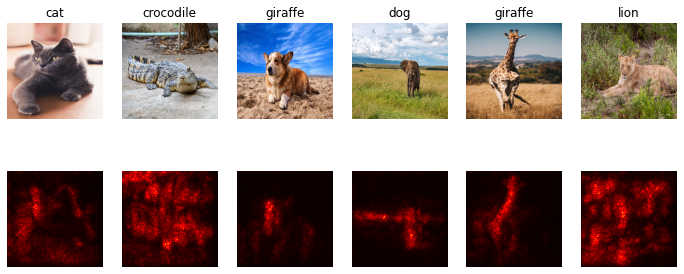

In [41]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_rn18_u[temp_img], model_rn18_u)

# Creating an Architecture from scratch and training on our dataset

### A ResNet-18 model is implemented from scratch for the image classification. The model is implemented in PyTorch using Convolution, Batch Normalization, Maxpool, and Dropout layers.

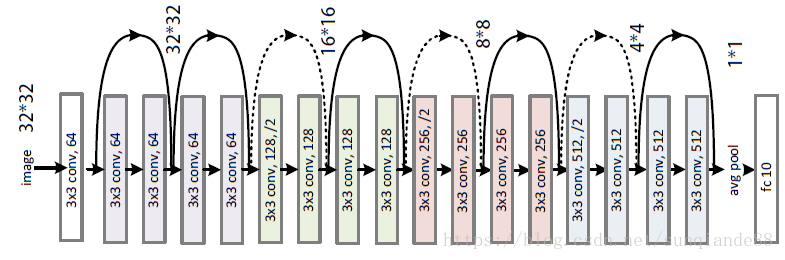
<br>
An input image of size (224 x 224) with 3 channels is passed through the first convolution layer. The number of filters used is 64 with kernel size (7 x 7) stride (2 x 2) and padding (3 x 3). This changes input image size from (224x224x3) to (112x112x64). The output of the first convolution layer is passed through a batch normalization layer and a maxpool layer from which we will get the output of the first block with size (56 x 56) and 64 channels. 


The output from Block-1 is passed through Block-2 where the image size is not changing. 
The first Convolution layer in Block -3 transforms the image to (28x28) image with 128 channels using a 3x3 kernel and 2x2 stride with 1x1 padding. The Batchnormaliztion and ReLU function is then applied on it. The second convolution layer takes this image as input and outputs the image with the same shape (28x28x128). 


The residual connection is applied by adding the output of Block-2, which is a (56x56x64) image, to the output of Block-3, which is a (28x28x128) image. The output of Block-2 is converted to (28x28x128) image by applying a convolution with (1 x1) filter and (2 x2) stride. The input channels will be 64 and the output channels will be 128. 


Whenever there is a need to adjust output to make it possible to apply a Residual connection a Convolution block is used, and whenever the input and output are the same Identity block is used.


Similarly, all the other blocks are created. 
After the Block-5, an average pooling operation is carried out where the image of size (7x7x512) is reduced to image of size (1x1x512) using a filter of size (7 x 7) and stride of 1. This image is flattened and passed to fully connected layers. The output from the last fully connected layer will be a vector of size equal to number of classes.


In [22]:
from image_classification import Cnn

model_own = Cnn(6).to(device = DEVICE)

optimizer = torch.optim.Adam(model_own.parameters(), lr=0.001)
loss_type = torch.nn.CrossEntropyLoss()


Epoch:  0 , loss is:  1.8024013042449951
Epoch:  10 , loss is:  1.5189521312713623
Epoch:  20 , loss is:  1.4460386037826538
Epoch:  30 , loss is:  1.5424131155014038
Epoch:  40 , loss is:  1.449689269065857
Epoch:  50 , loss is:  1.2223812341690063
Epoch:  60 , loss is:  1.3745754957199097
Epoch:  70 , loss is:  1.1335880756378174
Epoch:  80 , loss is:  1.3793739080429077
Epoch:  90 , loss is:  1.1814308166503906
Epoch:  100 , loss is:  1.2011343240737915
Epoch:  110 , loss is:  1.171242117881775
Epoch:  120 , loss is:  0.9300402998924255
Epoch:  130 , loss is:  0.9780402779579163
Epoch:  140 , loss is:  0.9554249048233032
Epoch:  150 , loss is:  0.9783773422241211
Epoch:  160 , loss is:  1.1869224309921265
Epoch:  170 , loss is:  0.9232945442199707
Epoch:  180 , loss is:  0.9325585961341858
Epoch:  190 , loss is:  0.9242659211158752
Epoch:  200 , loss is:  1.0315712690353394
Epoch:  210 , loss is:  0.7773164510726929
Epoch:  220 , loss is:  0.6662363409996033
Epoch:  230 , loss is:  

<function matplotlib.pyplot.show>

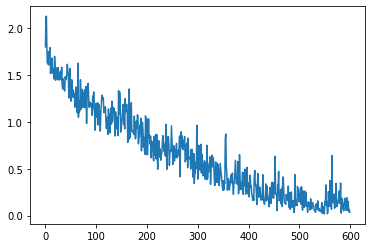

In [23]:
#Model Training
loss_graph = []
num_epochs = 600
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  model_own.train()
  optimizer.zero_grad()
  y_pred = model_own(x_batch)
  loss = loss_type(y_pred, y_batch)
  loss.backward()
  optimizer.step()
  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i, ", loss is: ", loss.cpu().item())

plt.plot(loss_graph)
plt.show

# Calculating Accuracy of our model


In [24]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch = images[random_no]
y_batch = labels[random_no]
y_pred = model_own(x_batch)

y_pred = torch.argmax(y_pred, axis = 1)

train_acc = ((torch.sum(y_pred == y_batch))/(batch_size))*100
print("Training accuracy: ", train_acc.item())

Training accuracy:  98.99999237060547


In [25]:
from image_classification import calculate_accuracy

y_pred_ = model_own(test_images)
y_pred = torch.argmax(y_pred_, axis=1)

accuracy = calculate_accuracy(test_images, y_pred_, test_labels, test_images.shape[0])

print("The accuracy of test data on Our own Resnet18 Model is: ", accuracy.item())

The accuracy of test data on Our own Resnet18 Model is:  70.0


### Confusion Matrix on our ResNet18 Model implemented from scratch

Confusion Matrix for Our ResNet18 Model


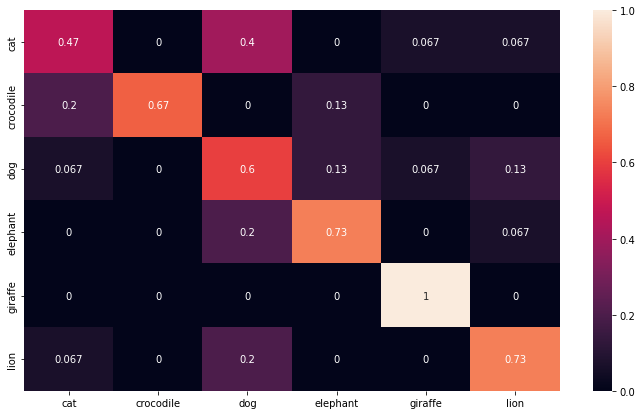

In [26]:
cf_model = confusion_matrix_display(y_pred, test_labels)

print("Confusion Matrix for Our ResNet18 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_model, annot=True)


### Qualitative Examples and Saliency Maps on our ResNet18 Model implemented from scratch

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

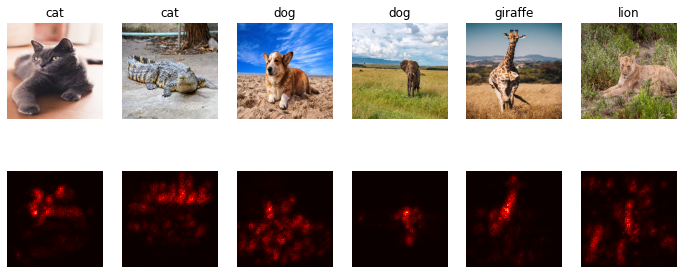

In [27]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred[temp_img], model_own)

# Results

# Observations for different Models:
1. **Resnet 18**: <br>
ResNet-18 is a convolutional neural network that is 18 layers deep. We trained 3 different types of ResNet18 models:
*   ***Pre-trained:*** Resnet18 is a simpler model which gave us moderately good results when compared to the other pre-trained models. When compared to other ResNet18 model implementations that we did, it definitely performed the best.
*   ***Untrained:*** The untrained model did not perform as well as the pre-trained model. The performance could have been improved with a larger training dataset.
* ***Implementing from Scratch:*** Our implementation of the ResNet18 Model following the architecture given in [this paper](https://arxiv.org/abs/1512.03385). It's performance was at par with that of the untrained ResNet18 model.

2. **ResNet50**: <br>
Since ResNet50 is a deeper model as compared to ResNet18, it look much longer to train this. Despite the depth of the model, it gave lesser accuracy than that of the pretrained ResNet18. This is because for deeper models, we need more training data and more number of epochs.

3. **GoogleNet**: <br>
GoogleNet performed best compared to all the models. It runs faster than other models. This higher computational efficiency is due to it's inception module in which a single layer contains multiple types of feature extractors.


4. **VGG**: <br>
The  main disadvantage of VGG lies in the fact that it took the most amount of time to train. Although the architecture is simple, the volume of the tensors after each layer are barely decreased, which leads to a higher execution time. Furthermore, accuracy of VGG is not as high as that of Residual Network models.

5. **AlexNet**: <br>
AlexNet is an inherently older architecture and performs badly among all the models that we trained on. The depth of this model is very less and hence it struggles to learn features from image sets. In order to get a higher accuracy, we would need to train it for longer.

# Best Models

The best two models were GoogleNet and ResNet18 (Pretrained). We have displayed the qualitative examples, confusion matrix and saliency maps (attribution methods) for each of the trianed models as they were trained. The performance of each of the model is summarized in the table below:
<br>
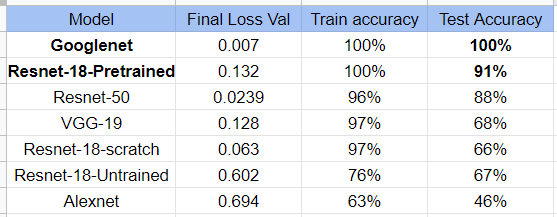
